# Notebook for [Recording gene expression order in DNA by CRISPR addition of retron barcodes (Bhattarai-Kline, S. et. al 2022, Nature)](https://www.nature.com/articles/s41586-022-04994-6)

#### MiSeq data ingestion and processing for targeted CRISPR spacer acquisition experiments.

These are the dependencies that the notebook uses. These should all be available through Anaconda's channels, and can be installed by running the following cell.
    
* fuzzysearch
* Biopython (if not, install: `pip install biopython`)
* seaborn (if not, install: `pip install seaborn`)
* numpy
* sickle (or sickle-trim -- if not, install: `conda install sickle-trim`; `conda install -c bioconda sickle-trim`)
* parallel-fastq-dump (if not, install: `pip install parallel-fastq-dump`; `conda install parallel-fastq-dump`)





### 1. Check dependencies -- install them if needed

In [1]:
import pkg_resources, sys
from pkg_resources import DistributionNotFound, VersionConflict

dependencies = [
    'biopython',
    'parallel-fastq-dump',
    'sickle-trim',
    'seaborn',
    'fuzzysearch',
    'pandas',
    'multiprocess',
    'sra-tools']

for d in dependencies:
    print (d)
    try:
        pkg_resources.require(d)
    except Exception as e:
        print (e)
        print ("installing dependency: ", d)
        ! conda install --yes --prefix {sys.prefix} $d


biopython
parallel-fastq-dump
sickle-trim
The 'sickle-trim' distribution was not found and is required by the application
installing dependency:  sickle-trim
Solving environment: done

# All requested packages already installed.

seaborn
fuzzysearch
pandas
multiprocess
sra-tools
The 'sra-tools' distribution was not found and is required by the application
installing dependency:  sra-tools
Solving environment: done

# All requested packages already installed.



### 2. Import packages / dependencies

In [5]:
import sys, os, glob, re, shutil, subprocess, itertools, multiprocessing
from collections import Counter, OrderedDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fuzzysearch
from difflib import SequenceMatcher

from multiprocessing import Process, Manager
import multiprocess as mp

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord



plt.rcParams['pdf.fonttype'] = 42
pd.options.mode.chained_assignment = None  # default='warn'


### 3. Load SRA run table
This dataframe contains metadata describing the sequencing files. You can find the file `SraRunTable.txt` [here](https://www.ncbi.nlm.nih.gov/Traces/study/?query_key=2&WebEnv=MCID_62f154c3d722cf4f612873a7&o=acc_s%3Aa&s=SRR19211554,SRR19211555,SRR19211556,SRR19211557,SRR19211558,SRR19211559,SRR19211560,SRR19211561,SRR19211562,SRR19211563,SRR19211564,SRR19211565,SRR19211566,SRR19211567,SRR19211568,SRR19211569,SRR19211570,SRR19211571,SRR19211572,SRR19211574,SRR19211575,SRR19211576,SRR19211577,SRR19211578,SRR19211579,SRR19211581,SRR19211582,SRR19211583,SRR19211584,SRR19211585,SRR19211586,SRR19211587,SRR19211588,SRR19211590,SRR19211591,SRR19211592,SRR19211593,SRR19211594,SRR19211595,SRR19211596,SRR19211597,SRR19211598,SRR19211599,SRR19211601,SRR19211602,SRR19211603,SRR19211604,SRR19211605,SRR19211606,SRR19211607,SRR19211608,SRR19211609,SRR19211610,SRR19211611,SRR19211612,SRR19211613,SRR19211614,SRR19211616,SRR19211617,SRR19211618,SRR19211619,SRR19211620,SRR19211621,SRR19211622,SRR19211623,SRR19211624,SRR19211625,SRR19211627,SRR19211628,SRR19211629,SRR19211630,SRR19211632,SRR19211634,SRR19211635,SRR19211636,SRR19211637,SRR19211638,SRR19211639,SRR19211640,SRR19211641,SRR19211642,SRR19211643,SRR19211644,SRR19211645,SRR19211646,SRR19211647,SRR19211648,SRR19211649,SRR19211650,SRR19211652,SRR19211654,SRR19211655,SRR19211656,SRR19211657,SRR19211658,SRR19211659,SRR19211660,SRR19211661,SRR19211663,SRR19211664,SRR19211665,SRR19211666,SRR19211667,SRR19211668,SRR19211669,SRR19211671,SRR19211672,SRR19211674,SRR19211675,SRR19211676,SRR19211677,SRR19211678,SRR19211679,SRR19211681,SRR19211682,SRR19211683,SRR19211684,SRR19211685,SRR19211686,SRR19211687,SRR19211688,SRR19211689,SRR19211690,SRR19211691,SRR19211692,SRR19211693,SRR19211694,SRR19211695,SRR19211697,SRR19211698,SRR19211699,SRR19211700,SRR19211701,SRR19211702,SRR19211703,SRR19211704,SRR19211705,SRR19211706,SRR19211707,SRR19211708,SRR19211709,SRR19211710,SRR19211711,SRR19211712,SRR19211714,SRR19211715,SRR19211716,SRR19211718,SRR19211719,SRR19211720,SRR19211721,SRR19211722,SRR19211723,SRR19211724,SRR19211725,SRR19211726,SRR19211727,SRR19211728,SRR19211730,SRR19211731,SRR19211732,SRR19211733,SRR19211734,SRR19211735,SRR19211736,SRR19211737,SRR19211738,SRR19211739,SRR19211740,SRR19211741,SRR19211742,SRR19211743,SRR19211744,SRR19211745,SRR19211746,SRR19211747,SRR19211748,SRR19211749,SRR19211750,SRR19211751,SRR19211752,SRR19211753,SRR19211754,SRR19211755,SRR19211756,SRR19211757,SRR19211758,SRR19211759,SRR19211761,SRR19211762,SRR19211763,SRR19211764,SRR19211765,SRR19211766,SRR19211767,SRR19211769,SRR19211770,SRR19211771,SRR19211772,SRR19211773,SRR19211774,SRR19211775,SRR19211776,SRR19211777,SRR19211778,SRR19211780,SRR19211781,SRR19211782,SRR19211783,SRR19211784,SRR19211785,SRR19211786,SRR19211787,SRR19211788,SRR19211789,SRR19211790,SRR19211791,SRR19211792,SRR19211793,SRR19211794,SRR19211795,SRR19211796,SRR19211797,SRR19211798,SRR19211799,SRR19211800,SRR19211801,SRR19211803,SRR19211804,SRR19211805,SRR19211806,SRR19211807,SRR19211808,SRR19211809,SRR19211811,SRR19211812,SRR19211813,SRR19211814,SRR19211815,SRR19211817,SRR19211818,SRR19211819,SRR19211820,SRR19211821,SRR19211823,SRR19211824,SRR19211825,SRR19211826,SRR19211827,SRR19211828,SRR19211829,SRR19211832,SRR19211833,SRR19211834,SRR19211835,SRR19211836,SRR19211837,SRR19211838,SRR19211839,SRR19211840,SRR19211841,SRR19211842,SRR19211844,SRR19211845,SRR19211847,SRR19211849,SRR19211850,SRR19211851,SRR19211853,SRR19211854,SRR19211855,SRR19211856,SRR19211857,SRR19211858,SRR19211859,SRR19211860,SRR19211861,SRR19211863,SRR19211865,SRR19211867,SRR19211868,SRR19211573,SRR19211589,SRR19211633,SRR19211651,SRR19211670,SRR19211696,SRR19211729,SRR19211779,SRR19211848,SRR19211852,SRR19211600,SRR19211615,SRR19211626,SRR19211631,SRR19211653,SRR19211673,SRR19211680,SRR19211713,SRR19211717,SRR19211768,SRR19211802,SRR19211810,SRR19211816,SRR19211822,SRR19211830,SRR19211831,SRR19211843,SRR19211862,SRR19211864,SRR19211866,SRR19211580,SRR19211662,SRR19211760,SRR19211846), or download it off our GitHub.

In [6]:
df_files = pd.read_csv("SraRunTable.txt")#[["Figure", "Panel", "Condition", "Replicate", "Exact filename"]]
# df_files["Figure"]

#### In this notebook, we'll focus on re-creating figure 4L

In [7]:
df_fig4 = df_files[(df_files["Figure"] == 4) & (df_files["panel"] == "l")]
df_fig4

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,BioSampleModel,Bytes,Center Name,Collection_date,...,panel,Platform,ReleaseDate,replicate,Sample Name,sample_type,section,SRA Study,strain,Also_present_in
117,SRR19211685,AMPLICON,246,61000238,PRJNA838025,SAMN28402444,"Microbe\, viral or environmental",34447900,GLADSTONE INSTITUTES,2021-05,...,l,ILLUMINA,2022-07-31T00:00:00Z,6,Main_4_l_BA_PCR5_rep6,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR5_rep6||ED_6b_PCR5_rep6
118,SRR19211686,AMPLICON,246,13623090,PRJNA838025,SAMN28402443,"Microbe\, viral or environmental",7334762,GLADSTONE INSTITUTES,2021-05,...,l,ILLUMINA,2022-07-31T00:00:00Z,6,Main_4_l_BA_PCR4_rep6,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR4_rep6||ED_6b_PCR4_rep6
120,SRR19211688,AMPLICON,246,18841740,PRJNA838025,SAMN28402442,"Microbe\, viral or environmental",10144811,GLADSTONE INSTITUTES,2021-05,...,l,ILLUMINA,2022-07-31T00:00:00Z,6,Main_4_l_BA_PCR3_rep6,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR3_rep6||ED_6b_PCR3_rep6
121,SRR19211689,AMPLICON,246,23466189,PRJNA838025,SAMN28402441,"Microbe\, viral or environmental",12585604,GLADSTONE INSTITUTES,2021-05,...,l,ILLUMINA,2022-07-31T00:00:00Z,6,Main_4_l_BA_PCR2_rep6,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR2_rep6||ED_6b_PCR2_rep6
122,SRR19211690,AMPLICON,246,10919197,PRJNA838025,SAMN28402440,"Microbe\, viral or environmental",5907360,GLADSTONE INSTITUTES,2021-05,...,l,ILLUMINA,2022-07-31T00:00:00Z,6,Main_4_l_BA_PCR1_rep6,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR1_rep6||ED_6b_PCR1_rep6
123,SRR19211691,AMPLICON,246,83581276,PRJNA838025,SAMN28402439,"Microbe\, viral or environmental",46420767,GLADSTONE INSTITUTES,2021-05,...,l,ILLUMINA,2022-07-31T00:00:00Z,5,Main_4_l_BA_PCR5_rep5,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR5_rep5||ED_6b_PCR5_rep5
124,SRR19211692,AMPLICON,246,16999434,PRJNA838025,SAMN28402438,"Microbe\, viral or environmental",8936264,GLADSTONE INSTITUTES,2021-05,...,l,ILLUMINA,2022-07-31T00:00:00Z,5,Main_4_l_BA_PCR4_rep5,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR4_rep5||ED_6b_PCR4_rep5
125,SRR19211693,AMPLICON,246,13551639,PRJNA838025,SAMN28402437,"Microbe\, viral or environmental",7116272,GLADSTONE INSTITUTES,2021-05,...,l,ILLUMINA,2022-07-31T00:00:00Z,5,Main_4_l_BA_PCR3_rep5,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR3_rep5||ED_6b_PCR3_rep5
126,SRR19211694,AMPLICON,246,14702023,PRJNA838025,SAMN28402436,"Microbe\, viral or environmental",7771401,GLADSTONE INSTITUTES,2021-05,...,l,ILLUMINA,2022-07-31T00:00:00Z,5,Main_4_l_BA_PCR2_rep5,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR2_rep5||ED_6b_PCR2_rep5
127,SRR19211695,AMPLICON,246,16777602,PRJNA838025,SAMN28402435,"Microbe\, viral or environmental",8825376,GLADSTONE INSTITUTES,2021-05,...,l,ILLUMINA,2022-07-31T00:00:00Z,5,Main_4_l_BA_PCR1_rep5,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR1_rep5||ED_6b_PCR1_rep5


### Download latest SRA-tools, and check that you can use fastq-dump
I've had issues installing and using SRA-tools in the past, since they stopped making the newer releases available on Conda / pip. The code below does the job on a Mac, but you can easily adapt it to work on a non-UNIX based machine. This is from the SRA-tools Git repo: 

| OS      | download url (to paste after the `wget` prompt) |
| ----------- | ----------- |
| Windows      | https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-win64.zip       |
| Ubuntu   | https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-ubuntu64.tar.gz        |
| CentOS   | https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-centos_linux64.tar.gz        |
| MacOSX   | https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-mac64.tar.gz        |
      
      
      
Note that the script below assumes that you have downloaded `sratoolkit 3.0.0`. If not, simply change the release number below.

In [8]:
%%sh 

wget https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/3.0.0/sratoolkit.3.0.0-mac64.tar.gz
tar -xvzf sratoolkit.3.0.0-mac64.tar.gz 
sratoolkit.3.0.0-mac64/bin/fastq-dump --stdout -X 2 SRR390728

--2022-08-09 15:08:50--  https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/3.0.0/sratoolkit.3.0.0-mac64.tar.gz
Resolving ftp-trace.ncbi.nlm.nih.gov... 130.14.250.7, 165.112.9.229
Connecting to ftp-trace.ncbi.nlm.nih.gov|130.14.250.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81779990 (78M) [application/x-gzip]
Saving to: 'sratoolkit.3.0.0-mac64.tar.gz'

     0K .......... .......... .......... .......... ..........  0%  344K 3m52s
    50K .......... .......... .......... .......... ..........  0%  696K 2m53s
   100K .......... .......... .......... .......... ..........  0% 9.85M 1m58s
   150K .......... .......... .......... .......... ..........  0%  427K 2m15s
   200K .......... .......... .......... .......... ..........  0% 29.8M 1m49s
   250K .......... .......... .......... .......... ..........  0% 71.3M 91s
   300K .......... .......... .......... .......... ..........  0%  689K 94s
   350K .......... .......... .......... .......... ..........  0% 31.5

@SRR390728.1 1 length=72
CATTCTTCACGTAGTTCTCGAGCCTTGGTTTTCAGCGATGGAGAATGACTTTGACAAGCTGAGAGAAGNTNC
+SRR390728.1 1 length=72
;;;;;;;;;;;;;;;;;;;;;;;;;;;9;;665142;;;;;;;;;;;;;;;;;;;;;;;;;;;;;96&&&&(
@SRR390728.2 2 length=72
AAGTAGGTCTCGTCTGTGTTTTCTACGAGCTTGTGTTCCAGCTGACCCACTCCCTGGGTGGGGGGACTGGGT
+SRR390728.2 2 length=72
;;;;;;;;;;;;;;;;;4;;;;3;393.1+4&&5&&;;;;;;;;;;;;;;;;;;;;;<9;<;;;;;464262


### 4. Download the FASTQs, using `fastq-dump`, and trim FASTQs, using [`sickle-trim`](https://github.com/najoshi/sickle)
This allows us to fetch the FASTQs from NCBI using the `sra-tools` package.

In [9]:
for file in df_fig4["Run"].values:
    print (file)
        
    ! sratoolkit.3.0.0-mac64/bin/fastq-dump -A $file -O ./fastqs --split-files --gzip --verbose

    ## files will be downloaded as `SRR19211756_1.fastq.gz`
    
    fn = df_fig4.loc[df_fig4['Run'] == file, ['Library Name']]["Library Name"].item()
    print (fn)
    
    print ("\ntrimming files\n")
    print ("./fastqs/{0}_1.fastq.gz".format(file))
    cmd = "sickle se -f ./fastqs/{0}_1.fastq.gz -t sanger \
                -o ./fastqs/{1}_trimmed.fastq".format(file, fn)
    os.system(cmd)
    
    print ("="*60)

SRR19211685
Rejected 247346 READS because READLEN < 1
Read 247346 spots for SRR19211685
Written 247346 spots for SRR19211685
msSBK_18_174

trimming files

./fastqs/SRR19211685_1.fastq.gz

FastQ records kept: 247345
FastQ records discarded: 1

SRR19211686
Rejected 55227 READS because READLEN < 1
Read 55227 spots for SRR19211686
Written 55227 spots for SRR19211686
msSBK_17_46

trimming files

./fastqs/SRR19211686_1.fastq.gz

FastQ records kept: 55224
FastQ records discarded: 3

SRR19211688
Rejected 76383 READS because READLEN < 1
Read 76383 spots for SRR19211688
Written 76383 spots for SRR19211688
msSBK_17_34

trimming files

./fastqs/SRR19211688_1.fastq.gz

FastQ records kept: 76369
FastQ records discarded: 14

SRR19211689
Rejected 95131 READS because READLEN < 1
Read 95131 spots for SRR19211689
Written 95131 spots for SRR19211689
msSBK_17_22

trimming files

./fastqs/SRR19211689_1.fastq.gz

FastQ records kept: 95116
FastQ records discarded: 15

SRR19211690
Rejected 44266 READS because 

### 5. Set global variables
* `Repeat`: the repeat sequence found separating the endogenous spacers of the E. coli Type I-E CRISPR system;
* `Old_SPCR1-4`: the spacers found endogenously in the  E. coli Type I-E CRISPR array.
* `dist_repeat` and `dist_oldSPCRs` set "fuzziness", or how flexible the functions run below will be to mismatches between the target and query sequences (Repeats + Spacers, and sequences extracted from the parsed reads, respectively).

In [10]:
# These are the sequences found in the CRISPR array.
Repeat = 'GTGTTCCCCGCGCCAGCGGGGATAAACC'
Old_SPCR1 = 'GAGCACAAATATCATCGCTCAAACCACTTACGG'
Old_SPCR2 = 'GCCTCGCTGTAAATTCCAAAAACGATCTCTATA'
Old_SPCR3 = 'GACAGTACCGGAGTTTGACGGTGCCAACGGCGG'
Old_SPCR4 = 'GACAATCAGGGAACGATTGTTGACACTGTAAAA'

# Sets the overall fuzziness
dist_repeat = 4
dist_oldSPCRs = 5
dict_data = {}

### 7. Define functions that will be used throughout the notebook

In [11]:

def get_spcrs(sequence):
    last_rep = fuzzysearch.find_near_matches(Repeat[0:15], sequence, max_l_dist=3)
    results = fuzzysearch.find_near_matches(Repeat, sequence, max_l_dist=6)
    
    if ((len(results) == 3) and (len(last_rep) >= 1) and (last_rep[len(last_rep)-1].start > results[len(results)-1].start)):
        spacer_list = [sequence[results[0].end:results[1].start]]
        spacer_list.append(sequence[results[1].end:results[2].start])
        spacer_list.append(sequence[results[2].end:last_rep[len(last_rep)-1].start])
        
    elif ((len(results) == 2) and (len(last_rep) >= 1) and (last_rep[len(last_rep)-1].start > results[len(results)-1].start)):
        spacer_list = [sequence[results[0].end:results[1].start]]
        spacer_list.append(sequence[results[1].end:last_rep[len(last_rep)-1].start])
        
    elif ((len(results) == 1) and (len(last_rep) >= 1) and (last_rep[len(last_rep)-1].start > results[len(results)-1].start)):
        spacer_list = [sequence[results[0].end:last_rep[len(last_rep)-1].start]]

    elif len(results) == 4:
        spacer_list = [sequence[results[0].end:results[1].start]]
        spacer_list.append(sequence[results[1].end:results[2].start])
        spacer_list.append(sequence[results[2].end:results[3].start])
        
    elif len(results) == 3:
        spacer_list = [sequence[results[0].end:results[1].start]]
        spacer_list.append(sequence[results[1].end:results[2].start])
        
    elif len(results) == 2:
        spacer_list = [sequence[results[0].end:results[1].start]]
    else:
        spacer_list = []
        
    return spacer_list

def not_existing(spacer):
    if SequenceMatcher(None,Old_SPCR1,spacer).ratio() < 0.83 \
    and SequenceMatcher(None,Old_SPCR2,spacer).ratio() < 0.83 \
    and SequenceMatcher(None,Old_SPCR3,spacer).ratio() < 0.83 \
    and SequenceMatcher(None,Old_SPCR4,spacer).ratio() < 0.83 \
    and SequenceMatcher(None,Repeat,spacer).ratio() < 0.83:
        return True
    else: return False

### functions for oComp_Order

def get_spcrs_11BC(sequence):
    last_rep = fuzzysearch.find_near_matches(Repeat[0:15], sequence, max_l_dist=3)
    results = fuzzysearch.find_near_matches(Repeat, sequence, max_l_dist=6)
    if ((len(results) == 3) and (len(last_rep) >= 1) and (last_rep[len(last_rep)-1].start > results[len(results)-1].start)):
        spacer_list = [sequence[results[0].end+5:results[1].start-5]]
        spacer_list.append(sequence[results[1].end+5:results[2].start-5])
        spacer_list.append(sequence[results[2].end+5:last_rep[len(last_rep)-1].start-5])
        
    elif ((len(results) == 2) and (len(last_rep) >= 1) and (last_rep[len(last_rep)-1].start > results[len(results)-1].start)):
        spacer_list = [sequence[results[0].end+5:results[1].start-5]]
        spacer_list.append(sequence[results[1].end+5:last_rep[len(last_rep)-1].start-5])
        
    elif ((len(results) == 1) and (len(last_rep) >= 1) and (last_rep[len(last_rep)-1].start > results[len(results)-1].start)):
        spacer_list = [sequence[results[0].end+5:last_rep[len(last_rep)-1].start-5]]
    
    elif len(results) == 4:
        spacer_list = [sequence[results[0].end+5:results[1].start-5]]
        spacer_list.append(sequence[results[1].end+5:results[2].start-5])
        spacer_list.append(sequence[results[2].end+5:results[3].start-5])

    elif len(results) == 3:
        spacer_list = [sequence[results[0].end+5:results[1].start-5]]
        spacer_list.append(sequence[results[1].end+5:results[2].start-5])

    elif len(results) == 2:
        spacer_list = [sequence[results[0].end+5:results[1].start-5]]

    else:
        spacer_list = []
        
    return spacer_list

def matchesTarget(target,seq):
    if bool(fuzzysearch.find_near_matches(Target_dict[target], seq, max_l_dist=mismatch_tol)):
        return True
    else:
        return False
    
def double_order(double):
    
    """input is two spacers from a double expansion
    returns tuple of coded spacers, e.g. ('A','B') or ('B','N')"""
    
    First = 'N'
    Second = 'N'
    for target in ['A','B']:

        if matchesTarget(target,double[0]):
            First = target
        if matchesTarget(target,double[1]):
            Second = target
    order = (First,Second)
    return order

def triple_order(triplet):
    """input is three spacers from a triple expansion
    returns tuple of coded spacers"""
    First = 'N'
    Second = 'N'
    Third = 'N'
    for target in ['A','B']:
        if matchesTarget(target,triplet[0]):
            First = target
        if matchesTarget(target,triplet[1]):
            Second = target
        if matchesTarget(target,triplet[2]):
            Third = target
    order = (First,Second,Third)
    return order


def multiprocess_spr(file):

    sampleID = os.path.splitext(file)[0] 
    
    ddd = \
    {
        "wildtype_sequences_three_read": [], 
        "wildtype_sequences_two_read": [],
        "wildtype_sequences_one_read": [], 
        "single_expansion_sequences_three_read_pos_one": [],
        "single_expansion_sequences_three_read_pos_two": [],
        "single_expansion_sequences_two_read_pos_one": [],
        "single_expansion_sequences_two_read_pos_two": [],
        "single_expansion_sequences_one_read": [],
        "single_replacement_sequences_two_read_pos_one": [],
        "double_expansion_sequences_two_read": [],
        "double_expansion_sequences_three_read": [],
        "triple_expansion_sequences_three_read": [],
        "SPCR1_deletion_sequences_two_read": [],
        "SPCR1_deletion_sequences_one_read": [],
        "weird_sequences_three_read": [],
        "weird_sequences_two_read": [],
        "weird_sequences_one_read": [],
        "weird_sequences_none_read": [],
        "new_SPCRs": [],
        "new_SPCRs_just_seqs": [],
        "unique_new_SPCRs": [],
        "Unaligned_SPCRs": [],
        "new_SPCR_lengths": [],
        "number_nonweird_reads": [],
        "nonfed_lengths": [],
        "fed_lengths": [],
        "total_reads": [],
    }
    

    fastq_reads = file
    print (fastq_reads)
    

    read_counter = Counter([str(i.seq) for i in SeqIO.parse(fastq_reads, "fastq")])
    
    ddd["total_reads"] = sum(read_counter.values())
    for read in read_counter:
        spacer_list = get_spcrs(read)
        
        #reads that have three clean spacers
        if len(spacer_list) == 3:
            
            if SequenceMatcher(None,Old_SPCR1,spacer_list[0]).ratio() > 0.83:
                if SequenceMatcher(None,Old_SPCR2,spacer_list[1]).ratio() > 0.83:
                    if SequenceMatcher(None,Old_SPCR3,spacer_list[2]).ratio() > 0.83:
                        ddd["wildtype_sequences_three_read"].extend([read]*read_counter[read])

    
            elif not_existing(spacer_list[0]) == True:
                if not_existing(spacer_list[1]) == True:
                    if not_existing(spacer_list[2]) == True:
                        ddd["triple_expansion_sequences_three_read"].extend([read]*read_counter[read])

                        if len(spacer_list[0]) < 61:
                            ddd["new_SPCRs"].extend([spacer_list[0]]*read_counter[read])
                        if len(spacer_list[1]) < 61:
                            ddd["new_SPCRs"].extend([spacer_list[1]]*read_counter[read])
                        if len(spacer_list[2]) < 61:
                            ddd["new_SPCRs"].extend([spacer_list[2]]*read_counter[read])
                    else:
                        ddd["double_expansion_sequences_three_read"].extend([read]*read_counter[read])
                        if len(spacer_list[0]) < 61:
                            ddd["new_SPCRs"].extend([spacer_list[0]]*read_counter[read])
                        if len(spacer_list[1]) < 61:
                            ddd["new_SPCRs"].extend([spacer_list[1]]*read_counter[read])
                else:
                    ddd["single_expansion_sequences_three_read_pos_one"].extend([read]*read_counter[read])
                    if len(spacer_list[0]) < 61:
                        ddd["new_SPCRs"].extend([spacer_list[0]]*read_counter[read])
                
            elif ((not_existing(spacer_list[0]) == False) and (not_existing(spacer_list[1]) == True)):
                ddd["single_expansion_sequences_three_read_pos_two"].extend([read]*read_counter[read])
                #not taking spacers from this
            else:
                ddd["weird_sequences_three_read"].extend([read]*read_counter[read])

        if len(spacer_list) == 2:
            if SequenceMatcher(None,Old_SPCR1,spacer_list[0]).ratio() > 0.83:
                if SequenceMatcher(None,Old_SPCR2,spacer_list[1]).ratio() > 0.83:
                    ddd["wildtype_sequences_two_read"].extend([read]*read_counter[read])
            elif not_existing(spacer_list[0]) == True:
                if not_existing(spacer_list[1]) == True:
                    ddd["double_expansion_sequences_two_read"].extend([read]*read_counter[read])
                    if len(spacer_list[0]) < 61:
                        ddd["new_SPCRs"].extend([spacer_list[0]]*read_counter[read])
                    if len(spacer_list[1]) < 61:
                        ddd["new_SPCRs"].extend([spacer_list[1]]*read_counter[read])
                else:
                    ddd["single_expansion_sequences_two_read_pos_one"].extend([read]*read_counter[read])
                    if len(spacer_list[0]) < 61:
                        ddd["new_SPCRs"].extend([spacer_list[0]]*read_counter[read])
                        
            elif ((not_existing(spacer_list[0]) == False) and (not_existing(spacer_list[1]) == True)):
                ddd["single_expansion_sequences_two_read_pos_two"].extend([read]*read_counter[read])
            else:
                ddd["weird_sequences_two_read"].extend([read]*read_counter[read])

        if len(spacer_list) == 1:
            if SequenceMatcher(None,Old_SPCR1,spacer_list[0]).ratio() > 0.83:
                ddd["wildtype_sequences_one_read"].extend([read]*read_counter[read])
            elif not_existing(spacer_list[0]) == True:
                ddd["single_expansion_sequences_one_read"].extend([read]*read_counter[read])
                if len(spacer_list[0]) < 61:
                    ddd["new_SPCRs"].extend([spacer_list[0]]*read_counter[read])
            else:
                ddd["weird_sequences_one_read"].extend([read]*read_counter[read])

        if len(spacer_list) == 0:
            ddd["weird_sequences_none_read"].extend([read]*read_counter[read])
    print (len(ddd["new_SPCRs"]), "new spacers found")
    print (ddd["total_reads"], "total reads in FASTQ")
    tbr = {file: ddd}

    return tbr

### tk. For each read in each FASTQ, extract new spacers and store them according to their characteristics and the characteristics of the CRISPR arrays from which they were extracted
The idea of this cell is to execute the function defined above as `multiprocess_spr`. This function will:
* setup a temporary dictionary, `ddd`, to store the new spacer data;
* generate a counter of the reads in the input FASTQ, for the sake of expediting the analysis;
* iterate through each read in the counter, extract and and determine the characteristics of the read and its spacer(s), such as:
    * does the read contain one or more spacers;
    * are the spacers **"old"** (one of the spacers found in the endogenous CRISPR array) or **"new"**;
* store the read and spacer information in the temp dictionary `ddd` as a dictionary ~ `{"FASTQ_n": ddd}`, where `ddd` is the dictionary with the information collected on all of the FASTQ's reads;
* return the dictionary for downstream analysis.    
     
Note that the function called to extract the spacers is `get_spcrs`, which takes as input a read, and outputs a list of spacers. This list of spacers is then processed by the rest of the `multiprocess_spr` function and the features detailed above are extracted and used to bin the spacers and reads, which are finally added to the temporary dictionary `ddd` as discussed above.    

This cell does most of the heavy lifting and takes a while to run because of the number of reads per FASTQ.      
To speed things up, we use multiprocessing to offload tasks to worker processes, and enables the analysis of multiple FASTQs in parallel.      
The number of processes run will be `cpu_count - 1`, where `cpu_count` is the number of CPUs in the system (i.e., on your laptop or cluster).

In [12]:
in_lst = glob.glob("./fastqs/*_trimmed.fastq")

with mp.Pool(multiprocessing.cpu_count()-1) as pool:
    #print ("here")
    rezie = pool.map(multiprocess_spr, in_lst)
    #print ("done I think")

./fastqs/msSBK_17_33_trimmed.fastq./fastqs/msSBK_17_34_trimmed.fastq./fastqs/msSBK_17_37_trimmed.fastq./fastqs/msSBK_18_174_trimmed.fastq./fastqs/msSBK_17_09_trimmed.fastq./fastqs/msSBK_18_169_trimmed.fastq./fastqs/msSBK_15_01_trimmed.fastq
./fastqs/msSBK_15_41_trimmed.fastq
./fastqs/msSBK_15_22_trimmed.fastq



./fastqs/msSBK_17_29_trimmed.fastq
./fastqs/msSBK_17_17_trimmed.fastq



2460 new spacers found
55270 total reads in FASTQ
./fastqs/msSBK_17_30_trimmed.fastq
3080 new spacers found
74736 total reads in FASTQ
./fastqs/msSBK_15_18_trimmed.fastq
3743 new spacers found
76369 total reads in FASTQ
./fastqs/msSBK_15_06_trimmed.fastq
2830 new spacers found
81027 total reads in FASTQ
./fastqs/msSBK_15_26_trimmed.fastq
3231 new spacers found
87117 total reads in FASTQ
./fastqs/msSBK_15_05_trimmed.fastq
3679 new spacers found
89390 total reads in FASTQ
./fastqs/msSBK_15_02_trimmed.fastq
1000 new spacers found
54931 total reads in FASTQ
./fastqs/msSBK_15_21_trimmed.fastq
13738 new spacers 

### Build a new dictionary, `dict_data`, with data for all FASTQs processed.
`dict_data` is structured as follows:

```
dict_data = {
    ./fastqs/FASTQ_1_trimmed.fastq : 
        {"wildtype_sequences_three_read": [reads], 
            ...
            "new_SPCRs": [new_spacers]},
    ./fastqs/FASTQ_2_trimmed.fastq : 
        {"wildtype_sequences_three_read": [reads], 
            ...
            "new_SPCRs": [new_spacers]},
    ...
    ./fastqs/FASTQ_n_trimmed.fastq : 
        {"wildtype_sequences_three_read": [reads], 
            ...
            "new_SPCRs": [new_spacers]},
            }
```
For all the data stored in the dictionary, refer to the function `multiprocess_spr` defined above.


In [13]:
#print (rezie[0].keys())
for i in rezie:
    dict_data.update(i)
print(dict_data.keys())

dict_keys(['./fastqs/msSBK_15_01_trimmed.fastq', './fastqs/msSBK_15_38_trimmed.fastq', './fastqs/msSBK_17_37_trimmed.fastq', './fastqs/msSBK_15_05_trimmed.fastq', './fastqs/msSBK_17_33_trimmed.fastq', './fastqs/msSBK_15_02_trimmed.fastq', './fastqs/msSBK_17_34_trimmed.fastq', './fastqs/msSBK_15_06_trimmed.fastq', './fastqs/msSBK_17_09_trimmed.fastq', './fastqs/msSBK_17_30_trimmed.fastq', './fastqs/msSBK_18_169_trimmed.fastq', './fastqs/msSBK_15_45_trimmed.fastq', './fastqs/msSBK_18_174_trimmed.fastq', './fastqs/msSBK_18_170_trimmed.fastq', './fastqs/msSBK_15_41_trimmed.fastq', './fastqs/msSBK_17_14_trimmed.fastq', './fastqs/msSBK_15_22_trimmed.fastq', './fastqs/msSBK_17_10_trimmed.fastq', './fastqs/msSBK_17_29_trimmed.fastq', './fastqs/msSBK_15_26_trimmed.fastq', './fastqs/msSBK_17_17_trimmed.fastq', './fastqs/msSBK_15_18_trimmed.fastq', './fastqs/msSBK_15_21_trimmed.fastq', './fastqs/msSBK_17_13_trimmed.fastq', './fastqs/msSBK_15_25_trimmed.fastq', './fastqs/msSBK_15_46_trimmed.fastq'

The dictionary `dict_data` contains lots of useful information. For instance, one can look up the total number of reads for any given FASTQ, as shown below:

In [14]:
#print (dict_data["./fastqs/msSBK_15_01_trimmed.fastq"]["total_reads"])

### Determine the order of spacers in each sequenced CRISPR array
To do this, we've defined that a retron-derived spacer is spacer that contains an 11-base region of the hypothetical prespacer, consisting of the 7-base barcode region, and 2 bases on either side (with one mismatch or indel allowed).   
For instance, an `A` retron-derived spacer would have an 11bp core region consisting of the following sequence: `GTTGCAGCAAC`.       
Similarly, a `B` retron-derived spacer would have an 11bp core region consisting of the following sequence: `GTCAGACTGAC`.     
Both of those are specified in the `Target_dict`, which is used to determine whether a spacer is an `A`, a `B`, or an `N` spacer -- the latter is any new spacer that is not classified as an `A` or a `B` spacer.    
The code below iterates through every FASTQ, generating a dictionary of the counts of every possible permutation of `ABN` spacers, both for double expansions and triple expansions. For instance, in the case of double expansions, the possibilities are:    
* `A, A`
* `A, B`
* `A, N`
* `B, B`
* `B, A`
* `B, N`
* `N, N`
* `N, A`
* `N, B`        

These counts are stored in the dictionaries `double_dict` and `triple_dict`.   

*Note that the function called is `get_spcrs_11BC`, because it involves a more 'relaxed' search for retron-derived spacers, as mentioned above*.

In [15]:
## "lenient analysis" code -- refer to https://github.com/Shipman-Lab/Spacer-Seq/blob/master/oComp_Ordering_11baseBC.py

# params
mismatch_tol = 1

double_options = [prod for prod in itertools.product('ABN', repeat=2)]
triple_options = [prod for prod in itertools.product('ABN', repeat=3)]

# sequence of spacers `A` and `B`. Change as needed.
Target_dict = {
    'A': "GTTGCAGCAAC",
    'B': "GTCAGACTGAC"
                }

count_dict = {}
percent_dict = {}
total_spcrs = {}

double_list = {}
triple_list = {}

double_dict = {}
triple_dict = {}

double_counts = {}
A_spacers = {}
B_spacers = {}

for file in glob.glob("./fastqs/*_trimmed.fastq"):
    sampleID = os.path.splitext(file)[0]

    fastq_reads = file
    print (fastq_reads)
    
    
    # init counters, dicts, lists, etc.
    count_dict[file] = {'A': 0, 'B': 0, 'N': 0}
    percent_dict[file] = {}
    total_spcrs[file] = 0

    double_dict[file] = {}
    triple_dict[file] = {}
      
    for double in double_options:
        double_dict[file][double] = 0
        
    for triple in triple_options:
        triple_dict[file][triple] = 0
    

    #Pull out spacer pairs and triplets
    
    double_list[file] = [get_spcrs_11BC(i) for i in dict_data[file]["double_expansion_sequences_two_read"]] + \
                        [get_spcrs_11BC(i) for i in dict_data[file]["double_expansion_sequences_three_read"]]
       
    triple_list[file] = [get_spcrs_11BC(i) for i in dict_data[file]["triple_expansion_sequences_three_read"]]
    
    #get order for doubles and triplets
    
    for double in double_list[file]:
        double_dict[file][double_order(double)] += 1
        
    for triplet in triple_list[file]:
        triple_dict[file][triple_order(triplet)] += 1

    # get spacer counts for each target
    
    double_counts[file] = []
    A_spacers[file] = []
    B_spacers[file] = []
    
    for seq_record in dict_data[file]["new_SPCRs"]:
        # print (seq_record)
        total_spcrs[file] +=1
        identity = []
        
        for target in Target_dict:
            if matchesTarget(target, seq_record):
                identity.append(target)
        #print (identity)
        
        if identity == []:
            identity.append('N')
    
        if identity == ['A']:
            A_spacers[file].append(seq_record)
    
        if identity == ['B']:
            B_spacers[file].append(seq_record)
    
        if len(identity) > 1:
            double_counts[file].append(seq_record)
    
        if len(identity) == 1:
            count_dict[file][identity[0]] += 1
    
    triple_dict[file]["total_reads"] = dict_data[file]["total_reads"]
    
    print('#A spacers = ',len(A_spacers[file]))
    print('#B Spacers = ',len(B_spacers[file]))
    print ()

./fastqs/msSBK_15_01_trimmed.fastq
#A spacers =  557
#B Spacers =  478

./fastqs/msSBK_15_38_trimmed.fastq
#A spacers =  38
#B Spacers =  8

./fastqs/msSBK_17_37_trimmed.fastq
#A spacers =  96
#B Spacers =  132

./fastqs/msSBK_15_05_trimmed.fastq
#A spacers =  317
#B Spacers =  363

./fastqs/msSBK_17_33_trimmed.fastq
#A spacers =  93
#B Spacers =  120

./fastqs/msSBK_15_02_trimmed.fastq
#A spacers =  4
#B Spacers =  7

./fastqs/msSBK_17_34_trimmed.fastq
#A spacers =  82
#B Spacers =  135

./fastqs/msSBK_15_06_trimmed.fastq
#A spacers =  350
#B Spacers =  561

./fastqs/msSBK_17_09_trimmed.fastq
#A spacers =  57
#B Spacers =  79

./fastqs/msSBK_17_30_trimmed.fastq
#A spacers =  24
#B Spacers =  38

./fastqs/msSBK_18_169_trimmed.fastq
#A spacers =  303
#B Spacers =  300

./fastqs/msSBK_15_45_trimmed.fastq
#A spacers =  456
#B Spacers =  603

./fastqs/msSBK_18_174_trimmed.fastq
#A spacers =  223
#B Spacers =  386

./fastqs/msSBK_18_170_trimmed.fastq
#A spacers =  179
#B Spacers =  386

./f

### tk. Generate a dataframe with the data collected above
The cell below generates a dataframe, `ordering_df`, generated by merging the dictionaries of double and triple spacer expansion ordering counts.   
Then, a second dataframe `big_df`, is generated, that merges the `ordering_df` with the metadata dataframe, described above.   
For the sake of calculating the ordering scores below, we've also added 2 columns to this new dataframe. These are the `Order`, or what the experimental order of signals were ($A \to B$ or $B \to A$); and PCR, which will allow us to average scores within biological replicates.

In [16]:
# make a dataframe with the data

ordering_df_1 = pd.DataFrame.from_dict(double_dict, orient = "index", columns = double_options).reset_index().rename(columns = {"index": "file"})
ordering_df_2 = pd.DataFrame.from_dict(triple_dict, orient = "index").reset_index().rename(columns = {"index": "file"})
ordering_df = pd.merge(left = ordering_df_1, right= ordering_df_2)

ordering_df["Library Name"] = ordering_df["file"].str.split(r'/fastqs/(.*?)_trimmed.fastq',expand=True)[1]

#display(ordering_df["Library Name"])
#display(df_fig4["Library Name"])


big_df = pd.merge(left = ordering_df, right = df_fig4, on="Library Name").drop("file", axis=1)

#display(big_df)
big_df["Order"]=big_df["Condition"].str.split("_", expand=True)[0]
big_df["PCR"] = big_df["Condition"].str.split("PCR", expand=True)[1]

This is what `big_df` looks like:

In [17]:
display(big_df)

,"(A, A)","(A, B)","(A, N)","(B, A)","(B, B)","(B, N)","(N, A)","(N, B)","(N, N)","(A, A, A)",...,ReleaseDate,replicate,Sample Name,sample_type,section,SRA Study,strain,Also_present_in,Order,PCR
0,0,0,4,1,0,7,9,5,258,0,...,2022-07-31T00:00:00Z,1,Main_4_l_AB_PCR1_rep1,Cell Culture,Main,SRP375182,bSLS.114,Main_5d_24+24hr_PCR1_rep1||ED_6a_PCR1_rep1,AB,1
1,0,0,0,0,0,0,0,0,1,0,...,2022-07-31T00:00:00Z,1,Main_4_l_BA_PCR4_rep1,Cell Culture,Main,SRP375182,bSLS.114,ED_6b_PCR4_rep1,BA,4
2,0,0,0,0,0,3,6,2,75,0,...,2022-07-31T00:00:00Z,4,Main_4_l_AB_PCR4_rep4,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_AB_48hr_PCR4_rep4||Main_5d_24+24hr_...,AB,4
3,0,0,4,0,0,8,4,7,283,0,...,2022-07-31T00:00:00Z,2,Main_4_l_AB_PCR1_rep2,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_AB_48hr_PCR1_rep2||Main_5d_24+24hr_...,AB,1
4,0,0,2,0,1,4,2,1,92,0,...,2022-07-31T00:00:00Z,6,Main_4_l_AB_PCR3_rep6,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_AB_48hr_PCR3_rep6||Main_5d_24+24hr_...,AB,3
5,0,0,0,0,0,0,0,0,4,0,...,2022-07-31T00:00:00Z,1,Main_4_l_BA_PCR1_rep1,Cell Culture,Main,SRP375182,bSLS.114,ED_6b_PCR1_rep1,BA,1
6,0,0,0,0,0,2,0,5,102,0,...,2022-07-31T00:00:00Z,6,Main_4_l_BA_PCR3_rep6,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR3_rep6||ED_6b_PCR3_rep6,BA,3
7,0,1,8,1,0,17,2,5,254,0,...,2022-07-31T00:00:00Z,2,Main_4_l_BA_PCR1_rep2,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR1_rep2||ED_6b_PCR1_rep2,BA,1
8,0,0,0,0,0,0,1,0,61,0,...,2022-07-31T00:00:00Z,6,Main_4_l_AB_PCR1_rep6,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_AB_48hr_PCR1_rep6||Main_5d_24+24hr_...,AB,1
9,0,0,0,0,0,0,0,0,12,0,...,2022-07-31T00:00:00Z,5,Main_4_l_BA_PCR3_rep5,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR3_rep5||ED_6b_PCR3_rep5,BA,3


And these are its columns:

In [18]:
big_df.columns

Index([                      ('A', 'A'),                       ('A', 'B'),
                             ('A', 'N'),                       ('B', 'A'),
                             ('B', 'B'),                       ('B', 'N'),
                             ('N', 'A'),                       ('N', 'B'),
                             ('N', 'N'),                  ('A', 'A', 'A'),
                        ('A', 'A', 'B'),                  ('A', 'A', 'N'),
                        ('A', 'B', 'A'),                  ('A', 'B', 'B'),
                        ('A', 'B', 'N'),                  ('A', 'N', 'A'),
                        ('A', 'N', 'B'),                  ('A', 'N', 'N'),
                        ('B', 'A', 'A'),                  ('B', 'A', 'B'),
                        ('B', 'A', 'N'),                  ('B', 'B', 'A'),
                        ('B', 'B', 'B'),                  ('B', 'B', 'N'),
                        ('B', 'N', 'A'),                  ('B', 'N', 'B'),
                        (

### tk. Calculate the "Ordering Scores"
As discussed in the main manuscript, we defined logical rules that should govern the ordering of spacers in the CRISPR arrays, with the hopes of infering the order of transcription of tagged genes (in this case, of distinct ncRNAs). 


Because spacers are acquired unidirectionally (see panel A of the figure below), with newer spacers closer to the leader sequence, we propose that, if transcript $A$ is expressed before transcript $B$, $A \to B \to \text{Leader}$ arrays should be more numerous than $B \to A \to \text{Leader}$ arrays. Conversely, if $B$ is expressed before $A$, the number of $B \to A \to \text{Leader}$ arrays should be greater than the number of $A \to B \to \text{Leader}$ arrays.


![Directional acquisition of new spacers](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41586-022-04994-6/MediaObjects/41586_2022_4994_Fig1_HTML.png?as=webp)

Another useful feature of using CRISPR arrays for recording is that, as hinted above, the Cas1–Cas2 complex acquires spacers derived from the plasmid and genome, which we call $N$ spacers. These untargeted acquisitions can also be used to interpret temporal information.      
    
Assuming that $N$ spacers are acquired at a constant rate, we can propose a set of rules that govern the order of $N \to A \to \text{Leader}$, $N \to B \to \text{Leader}$, $A \to N \to \text{Leader}$ and $B \to N \to \text{Leader}$ arrays, similarly to that described above.     


Explicitly, if during the experiment, spacer $A$ is available before spacer $B$, $A \to N \to \text{Leader}$ arrays should be observed more frequently than $N \to A \to \text{Leader}$ arrays. Conversely, $N \to B \to \text{Leader}$ arrays should outnumber $B \to N \to \text{Leader}$ arrays. This is because, on average and across the duration of the experiment, $B$ spacers will have been acquired more recently than $A$ spacers, and should tend to be found, on average, closer to the $\text{Leader}$.
    
In the opposite scenario, where spacer $B$ is expressed before spacer $A$, $N \to A \to \text{Leader}$ arrays should outnumber $A \to N \to \text{Leader}$ arrays, and $B \to N \to \text{Leader}$ arrays should likewise outnumber $N \to B \to \text{Leader}$ arrays.    
  
These rules can be states mathematically. We've defined the Ordering Score as the difference between possible array types (e.g., $[A \to B \to \text{Leader}] - [B \to A \to \text{Leader}]$ as the numberator and the sum of the two possibilities ($[A \to B \to \text{Leader}] + [B \to A \to \text{Leader}]$) as the denominator. This yields a score, $S \in [-1, 1]$, for each ordering rule ($A/B, A/N, B/N$). By definition, a positive value indicates that spacer $A$ was present before $B$ (i.e., the event recorded by $A$ happened before the event recorded by $B$); conversely, a negative value indicates that the $B$ spacers were present before the $A$ spacers. The magnitude of the score serves as a indicator of how well the the two signals, $A$ and $B$, are separated in time.    
    
Thus:    

$$S_{A/N} = \frac{\mathrm{f}_{A \to N \to \text{Leader}} - \mathrm{f}_{N \to A \to \text{Leader}}}{\mathrm{f}_{A \to N \to \text{Leader}} + \mathrm{f}_{N \to A \to \text{Leader}}}$$;     

$$S_{B/N} = \frac{\mathrm{f}_{N \to B \to \text{Leader}} - \mathrm{f}_{B \to N \to \text{Leader}}}{\mathrm{f}_{N \to B \to \text{Leader}} + \mathrm{f}_{B \to N \to \text{Leader}}}$$;  

$$S_{A/B} = \frac{\mathrm{f}_{B \to A \to \text{Leader}} - \mathrm{f}_{A \to B \to \text{Leader}}}{\mathrm{f}_{B \to A \to \text{Leader}} + \mathrm{f}_{A \to B \to \text{Leader}}}$$ 
     
In other words:    

$$S_{i/j} = \frac{\mathrm{f}_{j \to i \to \text{Leader}} - \mathrm{f}_{i \to j \to \text{Leader}}}{\mathrm{f}_{i \to j \to \text{Leader}} + \mathrm{f}_{j \to i \to \text{Leader}}}$$,      

Where $S_{i/j}$ is the ordering score associated with assuming an event linked to spacer $i$ happened before an event linked to spacer $j$,     
and $\mathrm{f}_{i \to j \to \text{Leader}}$ is the frequency of arrays that have the spacers ordered as $i \to j \to \text{Leader}$.

The following cell computes the score:

In [19]:
big_df["A/N"] = (big_df[('N', 'A')]-big_df[('A', 'N')])/(big_df[('A', 'N')]+big_df[('N', 'A')])
big_df["B/N"] = (big_df[('B', 'N')]-big_df[('N', 'B')])/(big_df[('B', 'N')]+big_df[('N', 'B')])
big_df["A/B"] = (big_df[('B', 'A')]-big_df[('A', 'B')])/(big_df[('A', 'B')]+big_df[('B', 'A')])

The following cell displays the `big_df` dataframe and saves it as `"full_data_ordering.csv"`.

In [20]:
display(big_df)
big_df.to_csv("full_data_ordering.csv")

,"(A, A)","(A, B)","(A, N)","(B, A)","(B, B)","(B, N)","(N, A)","(N, B)","(N, N)","(A, A, A)",...,sample_type,section,SRA Study,strain,Also_present_in,Order,PCR,A/N,B/N,A/B
0,0,0,4,1,0,7,9,5,258,0,...,Cell Culture,Main,SRP375182,bSLS.114,Main_5d_24+24hr_PCR1_rep1||ED_6a_PCR1_rep1,AB,1,0.384615,0.166667,1.0
1,0,0,0,0,0,0,0,0,1,0,...,Cell Culture,Main,SRP375182,bSLS.114,ED_6b_PCR4_rep1,BA,4,NaN,NaN,NaN
2,0,0,0,0,0,3,6,2,75,0,...,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_AB_48hr_PCR4_rep4||Main_5d_24+24hr_...,AB,4,1.000000,0.200000,NaN
3,0,0,4,0,0,8,4,7,283,0,...,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_AB_48hr_PCR1_rep2||Main_5d_24+24hr_...,AB,1,0.000000,0.066667,NaN
4,0,0,2,0,1,4,2,1,92,0,...,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_AB_48hr_PCR3_rep6||Main_5d_24+24hr_...,AB,3,0.000000,0.600000,NaN
5,0,0,0,0,0,0,0,0,4,0,...,Cell Culture,Main,SRP375182,bSLS.114,ED_6b_PCR1_rep1,BA,1,NaN,NaN,NaN
6,0,0,0,0,0,2,0,5,102,0,...,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR3_rep6||ED_6b_PCR3_rep6,BA,3,NaN,-0.428571,NaN
7,0,1,8,1,0,17,2,5,254,0,...,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR1_rep2||ED_6b_PCR1_rep2,BA,1,-0.600000,0.545455,0.0
8,0,0,0,0,0,0,1,0,61,0,...,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_AB_48hr_PCR1_rep6||Main_5d_24+24hr_...,AB,1,1.000000,NaN,NaN
9,0,0,0,0,0,0,0,0,12,0,...,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR3_rep5||ED_6b_PCR3_rep5,BA,3,NaN,NaN,NaN


To make the data plottable, we generate a smaller dataframe, `summarized_df`, that contains information about the filename, the order, the biological replicate, the PCR, the score and what kind of score it is. The dataframe is also saved as `"summarized_data_ordering.csv"`.

In [21]:
df_AN = pd.concat([big_df[['Library Name', 'Order', "replicate", "PCR", 'A/N']].rename(columns={'A/N':'Score'}), pd.DataFrame(['A/N']*len(big_df.index), columns=['Type'])], axis=1)
df_BN = pd.concat([big_df[['Library Name','Order', "replicate", "PCR", 'B/N']].rename(columns={'B/N':'Score'}), pd.DataFrame(['B/N']*len(big_df.index), columns=['Type'])], axis=1)
df_AB = pd.concat([big_df[['Library Name','Order', "replicate", "PCR", 'A/B']].rename(columns={'A/B':'Score'}), pd.DataFrame(['A/B']*len(big_df.index), columns=['Type'])], axis=1)
summarized_df = pd.concat([df_AN, df_BN, df_AB])
summarized_df.to_csv("summarized_data_ordering.csv")
display(summarized_df)


,Library Name,Order,replicate,PCR,Score,Type
0,msSBK_15_01,AB,1,1,0.384615,A/N
1,msSBK_15_38,BA,1,4,NaN,A/N
2,msSBK_17_37,AB,4,4,1.000000,A/N
3,msSBK_15_05,AB,2,1,0.000000,A/N
4,msSBK_17_33,AB,6,3,0.000000,A/N
...,...,...,...,...,...,...
49,msSBK_17_25,AB,4,3,NaN,A/B
50,msSBK_15_13,AB,1,2,NaN,A/B
51,msSBK_17_21,AB,6,2,NaN,A/B
52,msSBK_15_17,AB,2,2,NaN,A/B


Lastly, before plotting the data, we generated a final dataframe, `plt_df`, which contains a subset of the information of `summarized_df`, and calculates the average score per biological replicate, while keeping the information about what the order of the experiment was.

In [22]:
plt_df = summarized_df.groupby(["Type", "replicate", "Order"]).mean().reset_index(level=["Type"]).reset_index()
plt_df.to_csv("plotting_data_ordering.csv")
display(plt_df)

,replicate,Order,Type,Score
0,1,AB,A/B,1.000000
1,1,BA,A/B,NaN
2,2,AB,A/B,NaN
3,2,BA,A/B,0.000000
4,3,AB,A/B,1.000000
5,3,BA,A/B,-1.000000
6,4,AB,A/B,NaN
7,4,BA,A/B,NaN
8,5,AB,A/B,NaN
9,5,BA,A/B,NaN


This cell generates two overlaid plots:
* A swarmplot, showing the mean value of each score per biological replicate;
* A violinplot, to give a sense of the distribution of the scores.
   
Additionally, we've added a horizontal line at $0$, for the purpose of separating scores corresponding to "$A$ happened before $B$" (positive ordering score values) from scores corresponding to "$B$ happened before $A$" (negative ordering score values).

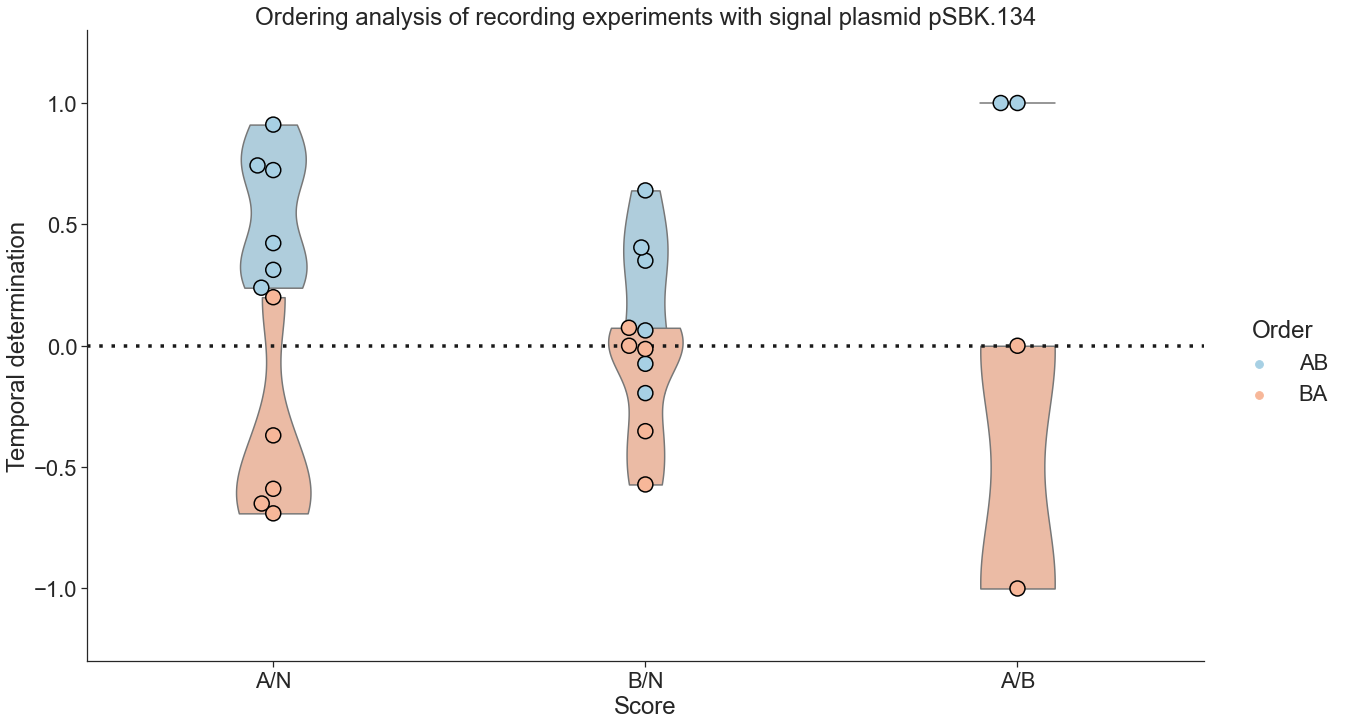

In [23]:
sns.set(font_scale = 2)
sns.set_style("ticks")

c_palette =  "RdBu_r" # "vlag" # "twilight_shifted" # "RdBu_r" #  PuOr_r

g = sns.catplot(x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=plt_df, kind="swarm", height=10.27, aspect=10.7/6.27, s=15, edgecolor='black', linewidth=1.5,
                palette= c_palette)

g.map(sns.violinplot, x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=plt_df, edgecolor='black', linewidth=1.5, 
        split = False, inner=None, bw=0.5, width =0.2, cut=0,
        dodge=False, alpha = 0.1,
        palette = c_palette,)

plt.ylim(-1.3, 1.3)

g.map(plt.axhline, y=0, ls=(0, (1, 2.5)), c='k', linewidth = 3.5)


g.set(xlabel='Score', ylabel='Temporal determination', title="Ordering analysis of recording experiments with signal plasmid pSBK.134")

g.savefig("ordering_analysis_134.pdf")

# Simulations

### Make mock figures for different ordering scores and show how that would affect interpretation of the figure

Define function that will simulate the spacer acquisition process

In [56]:
### code adapted from Santi Bhattarai-Kline's simulation scripts, also available on our lab GitHub

def gen_arrays(p_A_on, p_A_off, p_B_on, p_B_off, p_N, n_arrays, p, f):
    array_list = ["" for i in range(n_arrays)]
    
    file = f
    
    ## run first epoch
    for i in range(len(array_list)):
        
        t = '' + ("A" * int(np.random.poisson((p_A_on), 1)))\
               + ("B" * int(np.random.poisson((p_B_off), 1)))\
               + ('N' * int(np.random.poisson((p_N), 1)))
        
        if len(t) > 1:
            array_list[i] += random.choice(t)
        elif len(t) == 1:
            array_list[i] += t
                    
    ## run second epoch
    for i in range(len(array_list)):
        t = '' + ("A" * int(np.random.poisson((p_A_off), 1)))\
               + ("B" * int(np.random.poisson((p_B_on), 1)))\
               + ('N' * int(np.random.poisson((p_N), 1)))
        if len(t) > 1:
            array_list[i] += random.choice(t)
        elif len(t) == 1:
            array_list[i] += t

        # extract data 
        if len(array_list[i])>0:
            double_dict[file]["total expanded"] +=1
            spacers = [s for s in array_list[i]]
            for s in spacers:
                double_dict[file][s] +=1
            if len(spacers) == 2:
                double_dict[file][(spacers[0], spacers[1])] +=1

    double_dict[file]["total reads"] = n_arrays*corr_factor 
    double_dict[file]["PCR"] = p
    return double_dict[file]

# runs ths simulation
def run_sim(double_options, order, bioreps, pcrs,
           count_dict, double_dict,
           p_A_on, p_A_off, 
            p_B_on, p_B_off, 
            p_N, n_arrays, corr_factor):

    for o in order:
        for rep in bioreps:
            for p in pcrs: 
                file = rep

                double_dict[file] = {}

                for double in double_options:
                    double_dict[file][double] = 0

                double_dict[file]["total reads"] = 0
                double_dict[file]["total expanded"] = 0
                double_dict[file]["A"] = 0
                double_dict[file]["B"] = 0
                double_dict[file]["N"] = 0
                double_dict[file]["Order"] = o

                if o == "AB":
                    ddd = gen_arrays(p_A_on*corr_factor, p_A_off*corr_factor, 
                               p_B_on*corr_factor, p_B_off*corr_factor,
                               p_N*corr_factor, int(np.random.normal(n_arrays/corr_factor, scale = (n_arrays/corr_factor * 0.15))), p, file)
                elif o == "BA":
                    ddd = gen_arrays(p_A_off*corr_factor, p_A_on*corr_factor, 
                               p_B_off*corr_factor, p_B_on*corr_factor,
                               p_N*corr_factor, int(np.random.normal(n_arrays/corr_factor, scale = (n_arrays/corr_factor * 0.15))), p, file)
                
                elif o == "A/AB":
                    ddd = gen_arrays(p_A_on*corr_factor, p_A_on*corr_factor, 
                               p_B_on*corr_factor, p_B_off*corr_factor,
                               p_N*corr_factor, int(np.random.normal(n_arrays/corr_factor, scale = (n_arrays/corr_factor * 0.15))), p, file)
                    
                elif o == "-/AB":
                    ddd = gen_arrays(p_A_off*corr_factor, p_A_on*corr_factor, 
                               p_B_on*corr_factor, p_B_off*corr_factor,
                               p_N*corr_factor, int(np.random.normal(n_arrays/corr_factor, scale = (n_arrays/corr_factor * 0.15))), p, file)
                
                elif o == "AB/AB":
                    ddd = gen_arrays(p_A_on*corr_factor, p_A_on*corr_factor, 
                               p_B_on*corr_factor, p_B_on*corr_factor,
                               p_N*corr_factor, int(np.random.normal(n_arrays/corr_factor, scale = (n_arrays/corr_factor * 0.15))), p, file)

                count_dict[file+"_"+str(p)+"_"+str(o)] =  ddd


#### Situation 1: similar transcriptional recording experiment as in Figure 4L (pSBK134 A->B // B->A)
* **Order of events**: A turned on during epoch 1; B turned on during epoch 2
* **Promoter strength**: A and B are near matched
* **Promoter leakiness**: B is leakier than A

200'000 arrays generated per PCR indexed and sequenced; 6 PCRs per biological replicate (6 in total)

In [25]:
import random

double_options = [prod for prod in itertools.product('ABN', repeat=2)]

## sbk rates
# rate_A_on = 6.46E-5
# rate_A_off = 1.21E-5
# rate_B_on = 6.47E-5
# rate_B_off = 4.37E-5
# rate_N = 1.41E-3

## default params
p_A_on = 6.46e-4
p_A_off = 1.21e-4
p_B_on = 6.46e-4
p_B_off = 1.21e-4
p_N = 1.41e-2
n_arrays = 200000
corr_factor = 1

count_dict = {}
double_dict = {}

order = ["AB", "BA"]
bioreps = ["FQ1", "FQ2", "FQ3", "FQ4", "FQ5", "FQ6"]
pcrs = ["1","2","3","4","5", "6"]

run_sim(double_options, order, bioreps, pcrs,
           count_dict, double_dict,
           p_A_on, p_A_off, 
            p_B_on, p_B_off, 
            p_N, n_arrays, corr_factor)

In [26]:
small_df = pd.DataFrame(count_dict).T.reset_index().rename(columns={"index": "Exact filename"})
small_df["Replicate"] = small_df["Exact filename"].str.split("_", expand=True)[1]
small_df

,Exact filename,"(A, A)","(A, B)","(A, N)","(B, A)","(B, B)","(B, N)","(N, A)","(N, B)","(N, N)",total reads,total expanded,A,B,N,Order,PCR,Replicate
0,FQ1_1_AB,1,0,3,0,0,0,1,1,30,147866,4298,119,100,4115,AB,1,1
1,FQ1_2_AB,0,0,1,0,0,0,0,5,54,221625,6605,166,198,6301,AB,2,2
2,FQ1_3_AB,0,0,3,0,0,0,0,2,28,164594,4840,127,109,4637,AB,3,3
3,FQ1_4_AB,0,0,0,0,1,0,0,3,28,198168,5829,152,152,5557,AB,4,4
4,FQ1_5_AB,0,0,1,0,0,0,1,2,36,146795,4432,135,109,4228,AB,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,FQ6_2_BA,0,0,0,0,0,0,1,0,33,200162,5932,186,150,5630,BA,2,2
68,FQ6_3_BA,0,0,0,0,0,2,2,0,34,179450,5150,142,121,4925,BA,3,3
69,FQ6_4_BA,0,0,0,0,0,2,3,0,49,220812,6436,150,170,6170,BA,4,4
70,FQ6_5_BA,0,0,1,0,0,5,1,0,53,227946,6654,175,187,6352,BA,5,5


In [27]:
small_df["A/N"] = (small_df[('A', 'N')].astype(float)-small_df[('N', 'A')].astype(float))/(small_df[('A', 'N')].astype(float)+small_df[('N', 'A')].astype(float))
small_df["B/N"] = (small_df[('N', 'B')].astype(float)-small_df[('B', 'N')].astype(float))/(small_df[('B', 'N')].astype(float)+small_df[('N', 'B')].astype(float))
small_df["A/B"] = (small_df[('A', 'B')].astype(float)-small_df[('B', 'A')].astype(float))/(small_df[('A', 'B')].astype(float)+small_df[('B', 'A')].astype(float))
    
df_AN = pd.concat([small_df[['Exact filename','Order', "Replicate", "PCR", 'A/N']].rename(columns={'A/N':'Score'}), pd.DataFrame(['A/N']*len(small_df.index), columns=['Type'])], axis=1)
df_BN = pd.concat([small_df[['Exact filename', 'Order', "Replicate", "PCR", 'B/N']].rename(columns={'B/N':'Score'}), pd.DataFrame(['B/N']*len(small_df.index), columns=['Type'])], axis=1)
df_AB = pd.concat([small_df[['Exact filename','Order', "Replicate", "PCR", 'A/B']].rename(columns={'A/B':'Score'}), pd.DataFrame(['A/B']*len(small_df.index), columns=['Type'])], axis=1)
summarized_df = pd.concat([df_AN, df_BN, df_AB])
summarized_df = summarized_df[["Type", "Replicate", "Order", "Score"]].groupby(["Type", "Replicate", "Order"]).mean().reset_index(level=["Type"]).reset_index()

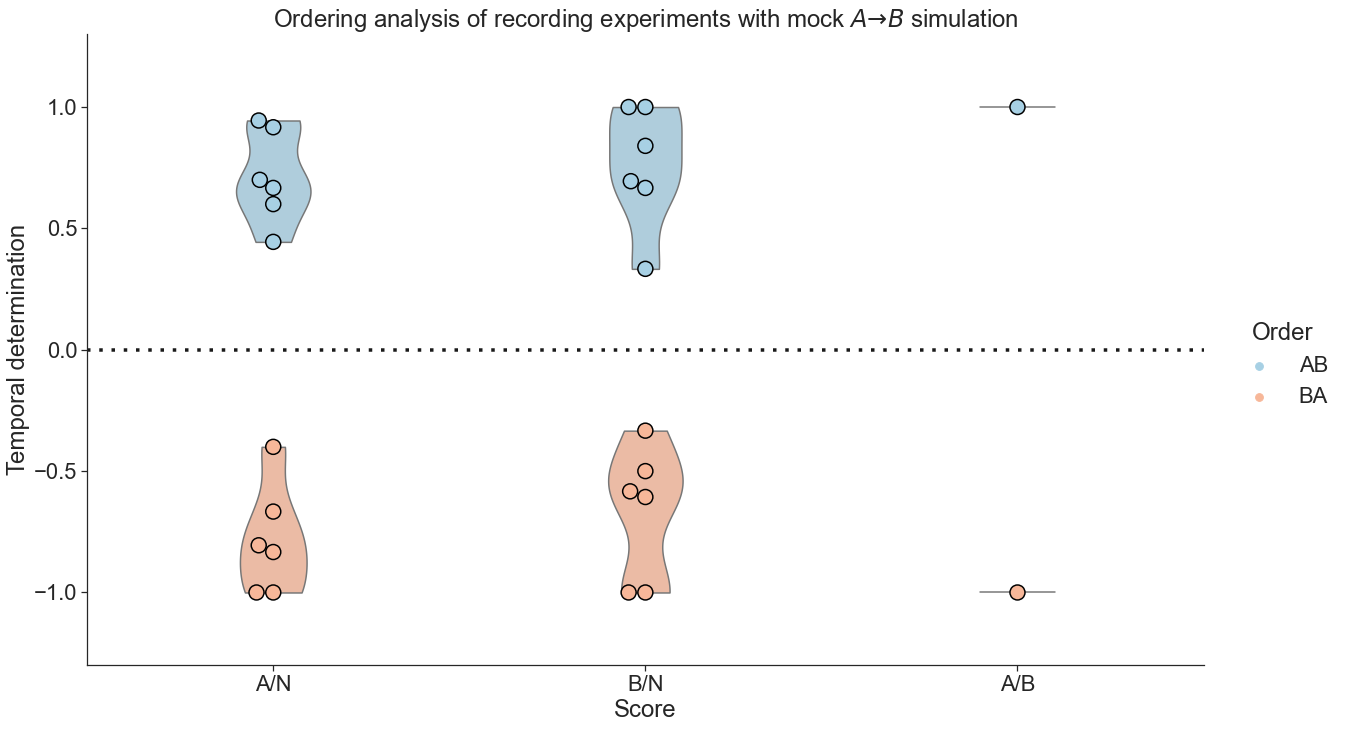

In [28]:
sns.set(font_scale = 2)
sns.set_style("ticks")

c_palette =  "RdBu_r" # "vlag" # "twilight_shifted" # "RdBu_r" #  PuOr_r

g = sns.catplot(x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=summarized_df, kind="swarm", height=10.27, aspect=10.7/6.27, s=15, edgecolor='black', linewidth=1.5,
                palette= c_palette)

g.map(sns.violinplot, x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=summarized_df, edgecolor='black', linewidth=1.5, 
        split = False, inner=None, bw=0.5, width =0.2, cut=0,
        dodge=False, alpha = 0.1,
        palette = c_palette,)

plt.ylim(-1.3, 1.3)

g.map(plt.axhline, y=0, ls=(0, (1, 2.5)), c='k', linewidth = 3.5)


g.set(xlabel='Score', ylabel='Temporal determination', title=r"Ordering analysis of recording experiments with mock $A \to B$ simulation")

g.savefig("ordering_analysis_mock_A-B_B-A_simulation_{0}_{1}_{2}_{3}_{4}.pdf".format(p_A_on, p_A_off, p_B_on, p_B_off, p_N))

#### Situation 2: A; A+B
* **Order of events**: A turned on during epoch 1; A+B turned on during epoch 2
* **Promoter strength**: A and B are near matched
* **Promoter leakiness**: A and B are both reasonably stringent

200'000 arrays generated per PCR indexed and sequenced; 6 PCRs per biological replicate (6 in total)

In [29]:
## good rates
p_A_on = 6.46e-4
p_A_off = 1.21e-4
p_B_on = 6.46e-4
p_B_off = 1.21e-4
p_N = 1.41e-2
n_arrays = 200000
corr_factor = 1

count_dict = {}
double_dict = {}


order = ["A/AB"]
bioreps = ["FQ1", "FQ2", "FQ3", "FQ4", "FQ5", "FQ6"]
pcrs = ["1","2","3","4","5", "6"]

run_sim(double_options, order, bioreps, pcrs,
           count_dict, double_dict,
           p_A_on, p_A_off, 
            p_B_on, p_B_off, 
            p_N, n_arrays, corr_factor)


In [30]:
small_df = pd.DataFrame(count_dict).T.reset_index().rename(columns={"index": "Exact filename"})
small_df["Replicate"] = small_df["Exact filename"].str.split("_", expand=True)[1]
#small_df

In [31]:
small_df["A/N"] = (small_df[('A', 'N')].astype(float)-small_df[('N', 'A')].astype(float))/(small_df[('A', 'N')].astype(float)+small_df[('N', 'A')].astype(float))
small_df["B/N"] = (small_df[('N', 'B')].astype(float)-small_df[('B', 'N')].astype(float))/(small_df[('B', 'N')].astype(float)+small_df[('N', 'B')].astype(float))
small_df["A/B"] = (small_df[('A', 'B')].astype(float)-small_df[('B', 'A')].astype(float))/(small_df[('A', 'B')].astype(float)+small_df[('B', 'A')].astype(float))
    
df_AN = pd.concat([small_df[['Exact filename','Order', "Replicate", "PCR", 'A/N']].rename(columns={'A/N':'Score'}), pd.DataFrame(['A/N']*len(small_df.index), columns=['Type'])], axis=1)
df_BN = pd.concat([small_df[['Exact filename', 'Order', "Replicate", "PCR", 'B/N']].rename(columns={'B/N':'Score'}), pd.DataFrame(['B/N']*len(small_df.index), columns=['Type'])], axis=1)
df_AB = pd.concat([small_df[['Exact filename','Order', "Replicate", "PCR", 'A/B']].rename(columns={'A/B':'Score'}), pd.DataFrame(['A/B']*len(small_df.index), columns=['Type'])], axis=1)
summarized_df = pd.concat([df_AN, df_BN, df_AB])
summarized_df = summarized_df[["Type", "Replicate", "Order", "Score"]].groupby(["Type", "Replicate", "Order"]).mean().reset_index(level=["Type"]).reset_index()

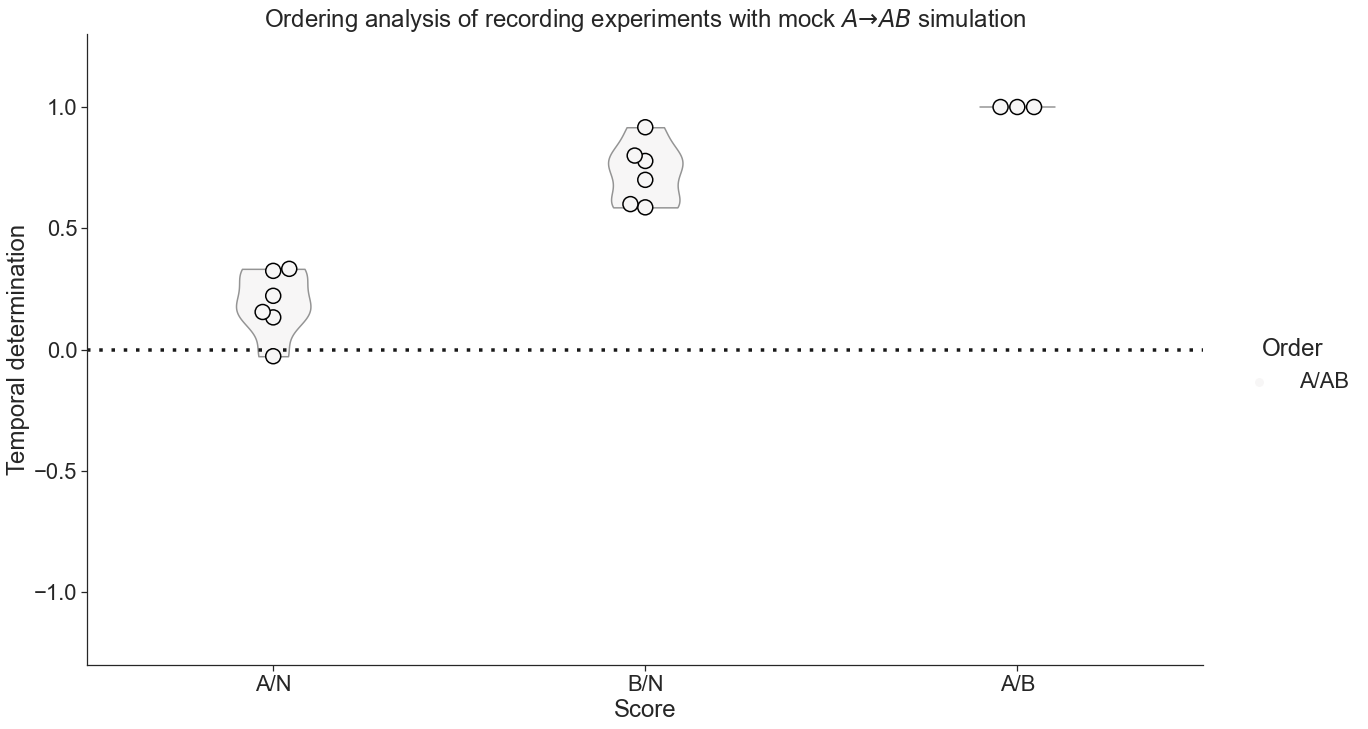

In [32]:
sns.set(font_scale = 2)
sns.set_style("ticks")

c_palette =  "RdBu_r" # "vlag" # "twilight_shifted" # "RdBu_r" #  PuOr_r

g = sns.catplot(x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=summarized_df, kind="swarm", height=10.27, aspect=10.7/6.27, s=15, edgecolor='black', linewidth=1.5,
                palette= c_palette)

g.map(sns.violinplot, x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=summarized_df, edgecolor='black', linewidth=1.5, 
        split = False, inner=None, bw=0.5, width =0.2, cut=0,
        dodge=False, alpha = 0.1,
        palette = c_palette,)

plt.ylim(-1.3, 1.3)

g.map(plt.axhline, y=0, ls=(0, (1, 2.5)), c='k', linewidth = 3.5)


g.set(xlabel='Score', ylabel='Temporal determination', title=r"Ordering analysis of recording experiments with mock $A \to AB$ simulation")

g.savefig("ordering_analysis_mock_A-AB_simulation_{0}_{1}_{2}_{3}_{4}.pdf".format(p_A_on, p_A_off, p_B_on, p_B_off, p_N))

#### Situation 3: none; A+B
* **Order of events**: neither turned on during epoch 1; A+B turned on during epoch 2
* **Promoter strength**: A and B are near matched
* **Promoter leakiness**: A and B are both reasonably stringent

200'000 arrays generated per PCR indexed and sequenced; 6 PCRs per biological replicate (6 in total)

In [64]:
## good rates
p_A_on = 6.46e-4
p_A_off = 1.21e-4
p_B_on = 6.46e-4
p_B_off = 1.21e-4
p_N = 1.41e-2
n_arrays = 200000
corr_factor = 1

count_dict = {}
double_dict = {}


order = ["-/AB"]
bioreps = ["FQ1", "FQ2", "FQ3", "FQ4", "FQ5", "FQ6"]
pcrs = ["1","2","3","4","5", "6"]

run_sim(double_options, order, bioreps, pcrs,
           count_dict, double_dict,
           p_A_on, p_A_off, 
            p_B_on, p_B_off, 
            p_N, n_arrays, corr_factor)

In [65]:
small_df = pd.DataFrame(count_dict).T.reset_index().rename(columns={"index": "Exact filename"})
small_df["Replicate"] = small_df["Exact filename"].str.split("_", expand=True)[1]

In [66]:
small_df["A/N"] = (small_df[('A', 'N')].astype(float)-small_df[('N', 'A')].astype(float))/(small_df[('A', 'N')].astype(float)+small_df[('N', 'A')].astype(float))
small_df["B/N"] = (small_df[('N', 'B')].astype(float)-small_df[('B', 'N')].astype(float))/(small_df[('B', 'N')].astype(float)+small_df[('N', 'B')].astype(float))
small_df["A/B"] = (small_df[('A', 'B')].astype(float)-small_df[('B', 'A')].astype(float))/(small_df[('A', 'B')].astype(float)+small_df[('B', 'A')].astype(float))
    
df_AN = pd.concat([small_df[['Exact filename','Order', "Replicate", "PCR", 'A/N']].rename(columns={'A/N':'Score'}), pd.DataFrame(['A/N']*len(small_df.index), columns=['Type'])], axis=1)
df_BN = pd.concat([small_df[['Exact filename', 'Order', "Replicate", "PCR", 'B/N']].rename(columns={'B/N':'Score'}), pd.DataFrame(['B/N']*len(small_df.index), columns=['Type'])], axis=1)
df_AB = pd.concat([small_df[['Exact filename','Order', "Replicate", "PCR", 'A/B']].rename(columns={'A/B':'Score'}), pd.DataFrame(['A/B']*len(small_df.index), columns=['Type'])], axis=1)
summarized_df = pd.concat([df_AN, df_BN, df_AB])
summarized_df = summarized_df[["Type", "Replicate", "Order", "Score"]].groupby(["Type", "Replicate", "Order"]).mean().reset_index(level=["Type"]).reset_index()

In [67]:
# display (small_df)

In [68]:
# display (summarized_df)

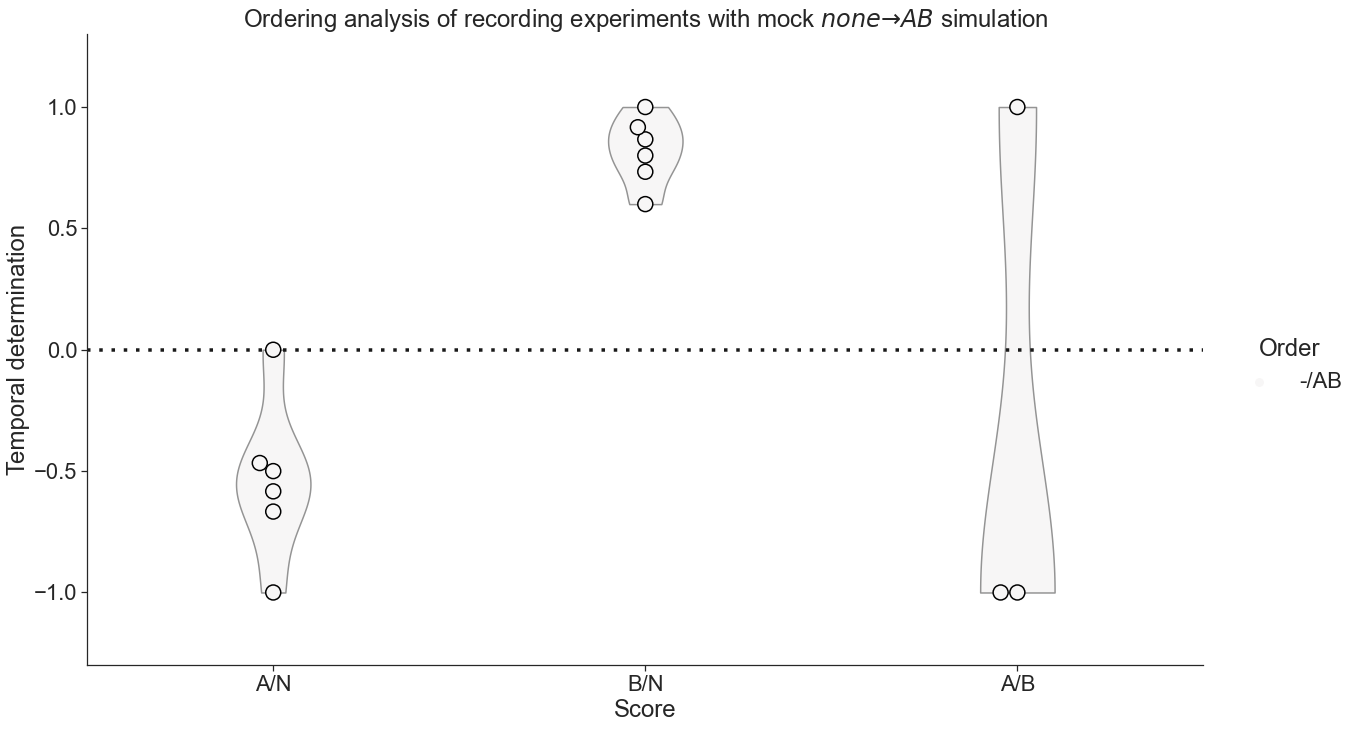

In [69]:
sns.set(font_scale = 2)
sns.set_style("ticks")

c_palette =  "RdBu_r" # "vlag" # "twilight_shifted" # "RdBu_r" #  PuOr_r

g = sns.catplot(x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=summarized_df, kind="swarm", height=10.27, aspect=10.7/6.27, s=15, edgecolor='black', linewidth=1.5,
                palette= c_palette)

g.map(sns.violinplot, x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=summarized_df, edgecolor='black', linewidth=1.5, 
        split = False, inner=None, bw=0.5, width =0.2, cut=0,
        dodge=False, alpha = 0.1,
        palette = c_palette,)

plt.ylim(-1.3, 1.3)

g.map(plt.axhline, y=0, ls=(0, (1, 2.5)), c='k', linewidth = 3.5)


g.set(xlabel='Score', ylabel='Temporal determination', title=r"Ordering analysis of recording experiments with mock $none \to AB$ simulation")

g.savefig("ordering_analysis_mock_none-AB_simulation_{0}_{1}_{2}_{3}_{4}.pdf".format(p_A_on, p_A_off, p_B_on, p_B_off, p_N))

#### Situation 4: A+B; A+B
* **Order of events**: A+B turned on during epoch 1; A+B turned on during epoch 2
* **Promoter strength**: A and B are near matched
* **Promoter leakiness**: A and B are both reasonably stringent

200'000 arrays generated per PCR indexed and sequenced; 6 PCRs per biological replicate (6 in total)

In [37]:
## good rates
p_A_on = 6.46e-4
p_A_off = 1.21e-4
p_B_on = 6.46e-4
p_B_off = 1.21e-4
p_N = 1.41e-2
n_arrays = 200000
corr_factor = 1

count_dict = {}
double_dict = {}


order = ["AB/AB"]
bioreps = ["FQ1", "FQ2", "FQ3", "FQ4", "FQ5", "FQ6"]
pcrs = ["1","2","3","4","5", "6"]

run_sim(double_options, order, bioreps, pcrs,
           count_dict, double_dict,
           p_A_on, p_A_off, 
            p_B_on, p_B_off, 
            p_N, n_arrays, corr_factor)

In [38]:
small_df = pd.DataFrame(count_dict).T.reset_index().rename(columns={"index": "Exact filename"})
small_df["Replicate"] = small_df["Exact filename"].str.split("_", expand=True)[1]
#small_df

In [39]:
small_df["A/N"] = (small_df[('A', 'N')].astype(float)-small_df[('N', 'A')].astype(float))/(small_df[('A', 'N')].astype(float)+small_df[('N', 'A')].astype(float))
small_df["B/N"] = (small_df[('N', 'B')].astype(float)-small_df[('B', 'N')].astype(float))/(small_df[('B', 'N')].astype(float)+small_df[('N', 'B')].astype(float))
small_df["A/B"] = (small_df[('A', 'B')].astype(float)-small_df[('B', 'A')].astype(float))/(small_df[('A', 'B')].astype(float)+small_df[('B', 'A')].astype(float))
    
df_AN = pd.concat([small_df[['Exact filename','Order', "Replicate", "PCR", 'A/N']].rename(columns={'A/N':'Score'}), pd.DataFrame(['A/N']*len(small_df.index), columns=['Type'])], axis=1)
df_BN = pd.concat([small_df[['Exact filename', 'Order', "Replicate", "PCR", 'B/N']].rename(columns={'B/N':'Score'}), pd.DataFrame(['B/N']*len(small_df.index), columns=['Type'])], axis=1)
df_AB = pd.concat([small_df[['Exact filename','Order', "Replicate", "PCR", 'A/B']].rename(columns={'A/B':'Score'}), pd.DataFrame(['A/B']*len(small_df.index), columns=['Type'])], axis=1)
summarized_df = pd.concat([df_AN, df_BN, df_AB])
summarized_df = summarized_df[["Type", "Replicate", "Order", "Score"]].groupby(["Type", "Replicate", "Order"]).mean().reset_index(level=["Type"]).reset_index()

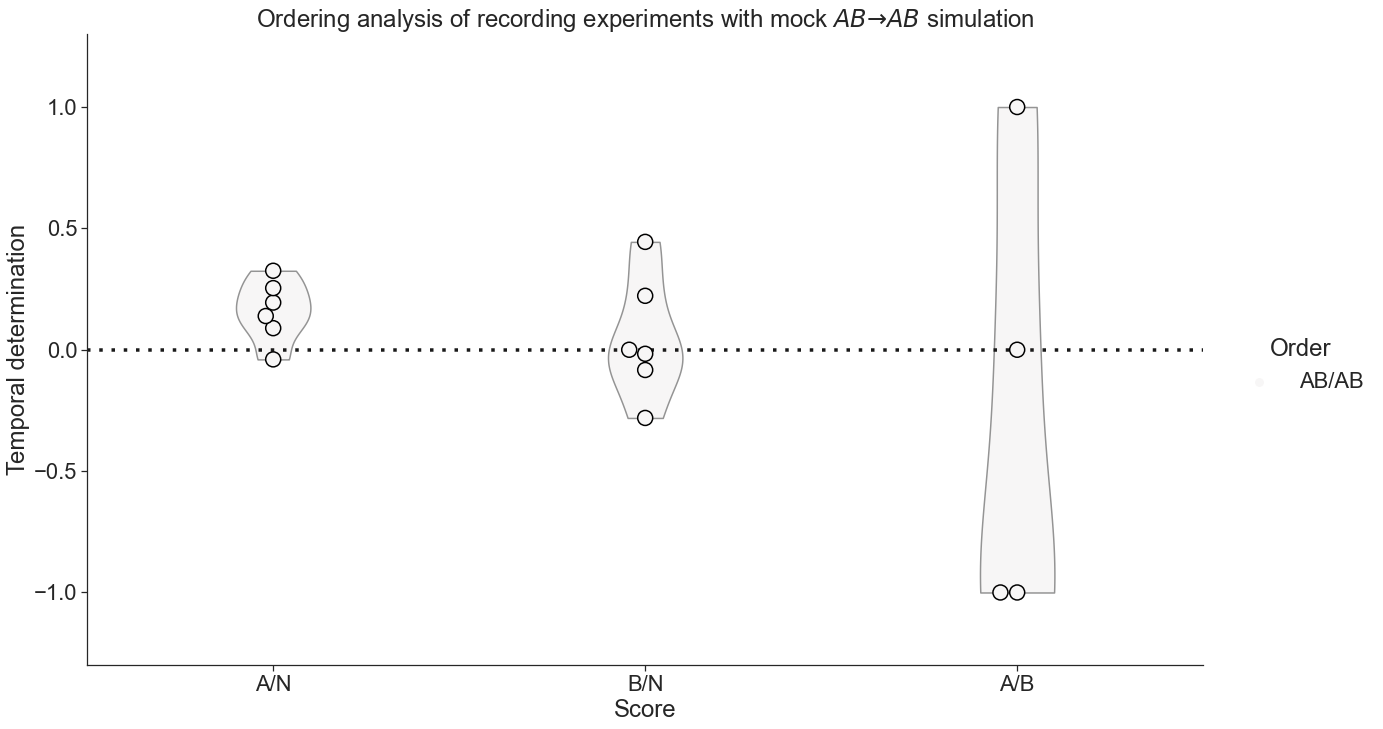

In [40]:
sns.set(font_scale = 2)
sns.set_style("ticks")

c_palette =  "RdBu_r" # "vlag" # "twilight_shifted" # "RdBu_r" #  PuOr_r

g = sns.catplot(x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=summarized_df, kind="swarm", height=10.27, aspect=10.7/6.27, s=15, edgecolor='black', linewidth=1.5,
                palette= c_palette)

g.map(sns.violinplot, x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=summarized_df, edgecolor='black', linewidth=1.5, 
        split = False, inner=None, bw=0.5, width =0.2, cut=0,
        dodge=False, alpha = 0.1,
        palette = c_palette,)

plt.ylim(-1.3, 1.3)

g.map(plt.axhline, y=0, ls=(0, (1, 2.5)), c='k', linewidth = 3.5)


g.set(xlabel='Score', ylabel='Temporal determination', title=r"Ordering analysis of recording experiments with mock $AB \to AB$ simulation")

g.savefig("ordering_analysis_mock_AB-AB_simulation_{0}_{1}_{2}_{3}_{4}.pdf".format(p_A_on, p_A_off, p_B_on, p_B_off, p_N))

#### Situation tk: A+B; B
* **Order of events**: A+B turned on during epoch 1; B turned on during epoch 2
* **Promoter strength**: A and B are near matched
* **Promoter leakiness**: A and B are both reasonably stringent

200'000 arrays generated per PCR indexed and sequenced; 6 PCRs per biological replicate (6 in total)

In [711]:
import random

double_options = [prod for prod in itertools.product('ABN', repeat=2)]

## sbk rates
# rate_A_on = 6.46E-5
# rate_A_off = 1.21E-5
# rate_B_on = 6.47E-5
# rate_B_off = 4.37E-5
# rate_N = 1.41E-3

## good rates
p_A_on = 6.46e-4
p_A_off = 1.21e-4
p_B_on = 6.47e-4
p_B_off = 1.21e-4
p_N = 1.41e-2
n_arrays = 200000

corr_factor = 1

count_dict = {}
double_dict = {}


order = ["AB/B"]
bioreps = ["FQ1", "FQ2", "FQ3", "FQ4", "FQ5", "FQ6"]
pcrs = ["1","2","3","4","5", "6"]

for o in order:
    for rep in bioreps:
        for p in pcrs: 
            file = rep

            double_dict[file] = {}
            triple_dict[file] = {}

            for double in double_options:
                double_dict[file][double] = 0

            for triple in triple_options:
                triple_dict[file][triple] = 0

            double_dict[file]["total reads"] = 0
            double_dict[file]["total expanded"] = 0
            double_dict[file]["A"] = 0
            double_dict[file]["B"] = 0
            double_dict[file]["N"] = 0
            double_dict[file]["Order"] = o
            
            if o == "AB/B":
                ##### gen_arrays(p_A_on, p_A_off, p_B_on, p_B_off, p_N, n_arrays, p)
                ddd = gen_arrays(p_A_on*corr_factor, p_A_off*corr_factor, 
                           p_B_on*corr_factor, p_B_on*corr_factor,
                           p_N*corr_factor, int(np.random.normal(n_arrays/corr_factor, scale = (n_arrays/corr_factor * 0.15))), p)
            
            count_dict[file+"_"+str(p)+"_"+str(o)] = ddd


In [712]:
small_df = pd.DataFrame(count_dict).T.reset_index().rename(columns={"index": "Exact filename"})
small_df["Replicate"] = small_df["Exact filename"].str.split("_", expand=True)[1]
#small_df

In [713]:
small_df["A/N"] = (small_df[('A', 'N')].astype(float)-small_df[('N', 'A')].astype(float))/(small_df[('A', 'N')].astype(float)+small_df[('N', 'A')].astype(float))
small_df["B/N"] = (small_df[('N', 'B')].astype(float)-small_df[('B', 'N')].astype(float))/(small_df[('B', 'N')].astype(float)+small_df[('N', 'B')].astype(float))
small_df["A/B"] = (small_df[('A', 'B')].astype(float)-small_df[('B', 'A')].astype(float))/(small_df[('A', 'B')].astype(float)+small_df[('B', 'A')].astype(float))
    
df_AN = pd.concat([small_df[['Exact filename','Order', "Replicate", "PCR", 'A/N']].rename(columns={'A/N':'Score'}), pd.DataFrame(['A/N']*len(small_df.index), columns=['Type'])], axis=1)
df_BN = pd.concat([small_df[['Exact filename', 'Order', "Replicate", "PCR", 'B/N']].rename(columns={'B/N':'Score'}), pd.DataFrame(['B/N']*len(small_df.index), columns=['Type'])], axis=1)
df_AB = pd.concat([small_df[['Exact filename','Order', "Replicate", "PCR", 'A/B']].rename(columns={'A/B':'Score'}), pd.DataFrame(['A/B']*len(small_df.index), columns=['Type'])], axis=1)
summarized_df = pd.concat([df_AN, df_BN, df_AB])
summarized_df = summarized_df[["Type", "Replicate", "Order", "Score"]].groupby(["Type", "Replicate", "Order"]).mean().reset_index(level=["Type"]).reset_index()

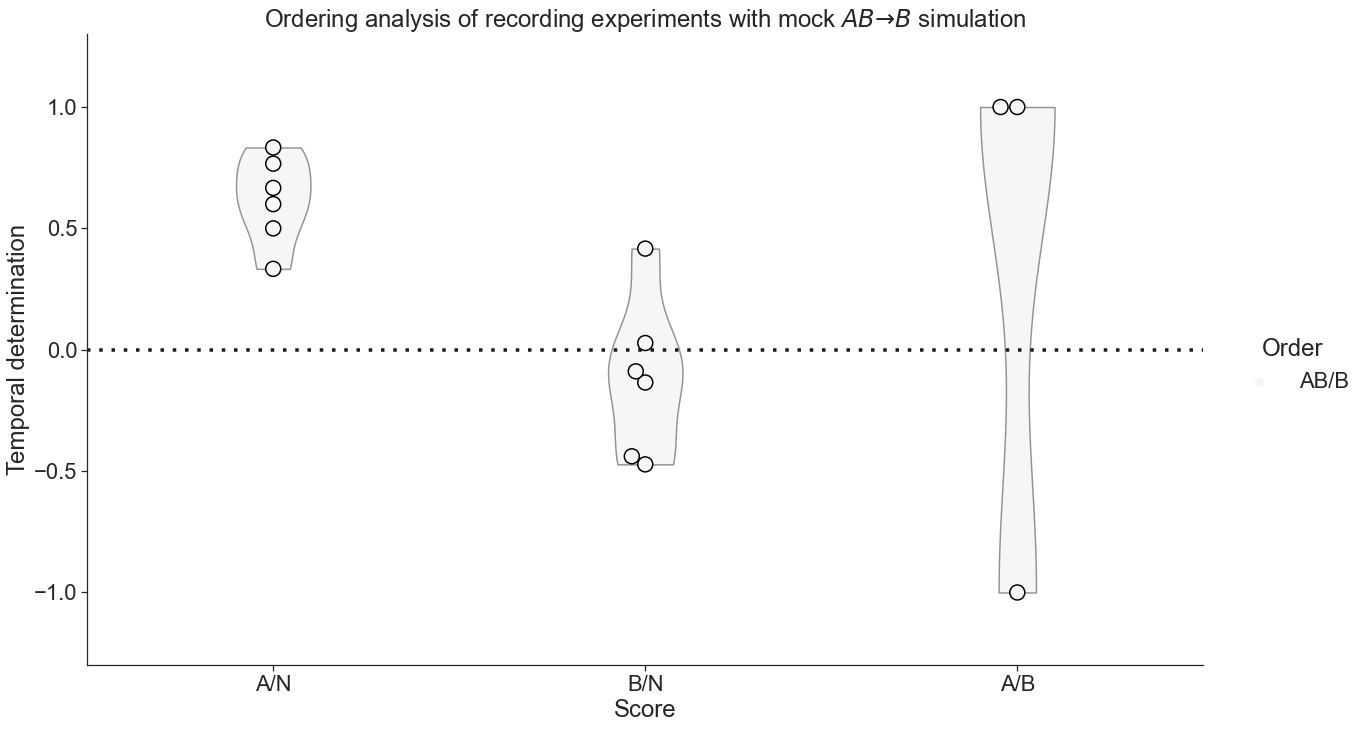

In [714]:
sns.set(font_scale = 2)
sns.set_style("ticks")

c_palette =  "RdBu_r" # "vlag" # "twilight_shifted" # "RdBu_r" #  PuOr_r

g = sns.catplot(x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=summarized_df, kind="swarm", height=10.27, aspect=10.7/6.27, s=15, edgecolor='black', linewidth=1.5,
                palette= c_palette)

g.map(sns.violinplot, x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=summarized_df, edgecolor='black', linewidth=1.5, 
        split = False, inner=None, bw=0.5, width =0.2, cut=0,
        dodge=False, alpha = 0.1,
        palette = c_palette,)

plt.ylim(-1.3, 1.3)

g.map(plt.axhline, y=0, ls=(0, (1, 2.5)), c='k', linewidth = 3.5)


g.set(xlabel='Score', ylabel='Temporal determination', title=r"Ordering analysis of recording experiments with mock $AB \to B$ simulation")

g.savefig("ordering_analysis_mock_AB-B_simulation_{0}_{1}_{2}_{3}_{4}.pdf".format(p_A_on, p_A_off, p_B_on, p_B_off, p_N))